In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import sklearn.metrics as met
import xgboost as xgb

In [2]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [9]:
party_df = pd.read_csv('party_df.csv')
party_df['종목코드'] = party_df['종목코드'].map(lambda x : str(x).rjust(6, '0'))
code_name = {code:name for code, name in zip(party_df['종목코드'].values, party_df['종목명'].values)}

In [10]:
code_name

{'005930': '삼성전자',
 '000660': 'SK하이닉스',
 '068270': '셀트리온',
 '005490': 'POSCO',
 '005380': '현대차',
 '051910': 'LG화학',
 '207940': '삼성바이오로직스',
 '035420': 'NAVER',
 '028260': '삼성물산',
 '105560': 'KB금융',
 '012330': '현대모비스',
 '015760': '한국전력',
 '055550': '신한지주',
 '017670': 'SK텔레콤',
 '032830': '삼성생명',
 '051900': 'LG생활건강',
 '034730': 'SK',
 '096770': 'SK이노베이션',
 '018260': '삼성에스디에스',
 '006400': '삼성SDI',
 '090430': '아모레퍼시픽',
 '033780': 'KT&G',
 '086790': '하나금융지주',
 '010950': 'S-Oil',
 '003550': 'LG',
 '000810': '삼성화재',
 '000270': '기아차',
 '011170': '롯데케미칼',
 '251270': '넷마블',
 '066570': 'LG전자',
 '009150': '삼성전기',
 '000030': '우리은행',
 '024110': '기업은행',
 '035720': '카카오',
 '036570': '엔씨소프트',
 '002790': '아모레G',
 '010130': '고려아연',
 '034220': 'LG디스플레이',
 '030200': 'KT',
 '009540': '현대중공업',
 '004020': '현대제철',
 '021240': '코웨이',
 '032640': 'LG유플러스',
 '000720': '현대건설',
 '004990': '롯데지주',
 '139480': '이마트',
 '023530': '롯데쇼핑',
 '018880': '한온시스템',
 '035250': '강원랜드',
 '161390': '한국타이어',
 '267250': '현대중공업지주',
 '0364

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
raw_data = {}
for code in code_name.keys():
     raw_data[code_name[code]] = \
        pdr.get_data_yahoo("{}.KS".format(code), 
                           start="2005-01-01", end="2019-05-01")

In [16]:
import pickle
with open('raw_data_20190115.pickle', 'rb') as handle:
    raw_data = pickle.load(handle)

In [18]:
len(raw_data.keys())

202

In [31]:
ix = 1
for stock, data in raw_data.items():
    if data.index[0] < pd.Timestamp('2007-01-01'):
        print(str(ix).rjust(3, '0'), '\t', data.index[0], stock)
        ix += 1

001 	 2005-09-29 00:00:00 AK홀딩스
002 	 2000-01-04 00:00:00 CJ
003 	 2004-12-24 00:00:00 CJ CGV
004 	 2000-01-04 00:00:00 CJ대한통운
005 	 2000-01-04 00:00:00 DB손해보험
006 	 2000-01-04 00:00:00 DB하이텍
007 	 2004-08-05 00:00:00 GS
008 	 2000-01-04 00:00:00 GS건설
009 	 2000-01-04 00:00:00 HDC
010 	 2005-09-29 00:00:00 JW중외제약
011 	 2006-05-31 00:00:00 JW홀딩스
012 	 2001-12-25 00:00:00 KB금융
013 	 2000-01-04 00:00:00 KCC
014 	 2000-01-04 00:00:00 KT
015 	 2000-01-04 00:00:00 KT&G
016 	 2006-12-01 00:00:00 LF
017 	 2004-11-05 00:00:00 LG
018 	 2004-07-23 00:00:00 LG디스플레이
019 	 2000-01-04 00:00:00 LG상사
020 	 2001-04-25 00:00:00 LG생활건강
021 	 2000-04-24 00:00:00 LG유플러스
022 	 2002-04-24 00:00:00 LG전자
023 	 2001-04-25 00:00:00 LG화학
024 	 2000-01-04 00:00:00 LS
025 	 2000-01-04 00:00:00 LS산전
026 	 2002-10-29 00:00:00 NAVER
027 	 2000-01-04 00:00:00 NH투자증권
028 	 2000-01-04 00:00:00 OCI
029 	 2000-01-04 00:00:00 POSCO
030 	 2002-03-13 00:00:00 S&T모티브
031 	 2000-01-04 00:00:00 S-Oil
032 	 2000-02-11 00:00:00 SBS

In [32]:
del_li = []
for stock, data in raw_data.items():
    if data.index[0] >= pd.Timestamp('2007-01-01'):
        del_li.append(stock)

In [34]:
for i in del_li:
    del raw_data[i]

In [35]:
len(raw_data)

152

# Base Line

In [36]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(penalty = 'l1', random_state = 42)

In [52]:
use_df = raw_data['S-Oil']

In [53]:
use_df

,Open,High,Low,Close,Adj Close,Volume,sto_K_5-3,sto_D_5-3
Date,,,,,,,,
2000-01-04,13000.0,13750.0,12725.0,12725.0,6684.140137,538800,NaN,NaN
2000-01-05,12325.0,12325.0,11225.0,11300.0,5935.620117,658400,NaN,NaN
2000-01-06,11750.0,11900.0,10150.0,10500.0,5515.398926,507800,NaN,NaN
2000-01-07,10450.0,11350.0,10275.0,11350.0,5961.883789,596000,NaN,NaN
2000-01-10,12000.0,12150.0,11500.0,11875.0,6237.656738,464800,47.916667,NaN
2000-01-11,11875.0,12225.0,11250.0,11450.0,6014.411133,606000,59.770115,NaN
2000-01-12,11600.0,11750.0,10800.0,11250.0,5909.356934,374400,53.012048,52.547771
2000-01-13,11500.0,11500.0,10150.0,10150.0,5331.553711,376800,0.000000,37.944664
2000-01-14,10950.0,10950.0,10575.0,10750.0,5646.717285,225800,28.915663,27.309237


In [41]:
def get_MACD(df, short_ma=12, long_ma=26, signal_period=9):
    ewm_12 = df['Close'].ewm(span = short_ma, min_periods = short_ma - 1).mean()
    ewm_26 = df['Close'].ewm(span = long_ma, min_periods = long_ma - 1).mean()
    df['MACD'] = ewm_12 - ewm_26
    df['MACDSignal'] = df['MACD'].ewm(span = signal_period, min_periods = signal_period-1).mean()
    df['MACDDiff'] = df['MACD'] - df['MACDSignal']
    return df

def get_Stochastic(df, n=14):
    df['sto_K_{}'.format(n)] = 100 * ((df.Close - df.Low.rolling(n).min()) / 
                                      (df.High.rolling(n).max() - df.Low.rolling(n).min()))
    df['sto_D_{}'.format(n)] = df['sto_K_{}'.format(n)].rolling(3).mean()
    return df

In [54]:
def get_stochastic2(df, setting):
    i, j = setting
    sto_K = 100 * ((df.Close - df.Low.rolling(i).min()) / 
          (df.High.rolling(i).max() - df.Low.rolling(i).min()))
    sto_D = 100 * (df.Close - df.Low.rolling(i).min()).rolling(j).sum() \
        / (df.High.rolling(i).max() - df.Low.rolling(i).min()).rolling(j).sum()
    df['sto_K_{}-{}'.format(i, j)] = sto_K
    df['sto_D_{}-{}'.format(i, j)] = sto_D

In [55]:
get_stochastic2(use_df, (5,3))

In [56]:
use_df

,Open,High,Low,Close,Adj Close,Volume,sto_K_5-3,sto_D_5-3
Date,,,,,,,,
2000-01-04,13000.0,13750.0,12725.0,12725.0,6684.140137,538800,NaN,NaN
2000-01-05,12325.0,12325.0,11225.0,11300.0,5935.620117,658400,NaN,NaN
2000-01-06,11750.0,11900.0,10150.0,10500.0,5515.398926,507800,NaN,NaN
2000-01-07,10450.0,11350.0,10275.0,11350.0,5961.883789,596000,NaN,NaN
2000-01-10,12000.0,12150.0,11500.0,11875.0,6237.656738,464800,47.916667,NaN
2000-01-11,11875.0,12225.0,11250.0,11450.0,6014.411133,606000,59.770115,NaN
2000-01-12,11600.0,11750.0,10800.0,11250.0,5909.356934,374400,53.012048,52.547771
2000-01-13,11500.0,11500.0,10150.0,10150.0,5331.553711,376800,0.000000,37.944664
2000-01-14,10950.0,10950.0,10575.0,10750.0,5646.717285,225800,28.915663,27.309237


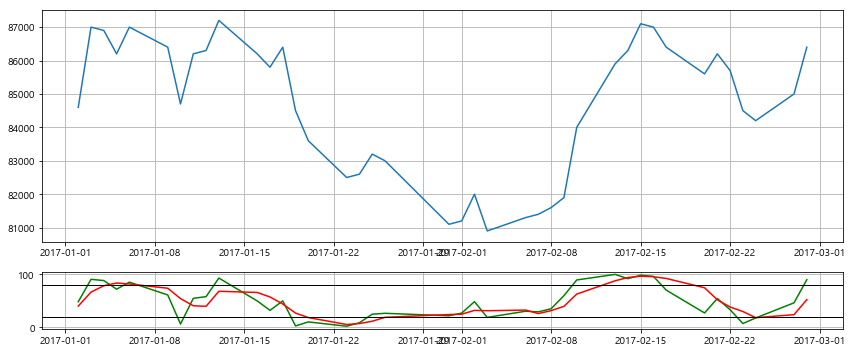

In [212]:
import matplotlib.pyplot as plt
import pandas_datareader.data as web

fig = plt.figure(figsize=(12, 5))

top_axes = plt.subplot2grid((4,4), (0,0), rowspan=3, colspan=4)
bottom_axes = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
bottom_axes.get_yaxis().get_major_formatter().set_scientific(False)


p = use_df[['sto_K_5-3', 'sto_D_5-3']].dropna().loc['2017-01-01':'2017-03-01']
p1 = p['sto_K_5-3'] - p['sto_D_5-3']

top_axes.plot(use_df.loc['2017-01-01':'2017-03-01'].index, 
              use_df.loc['2017-01-01':'2017-03-01']['Close'], label='Close')
top_axes.grid(True)
bottom_axes.plot(p.index, p['sto_K_5-3'], color='g')
bottom_axes.plot(p.index, p['sto_D_5-3'], color='r')

bottom_axes.axhline(y=20, color='k', linewidth=1)
bottom_axes.axhline(y=80, color='k', linewidth=1)
# bottom_axes.plot(p[p1 * p1.shift(1) < 0].index, 
#                  p[p1 * p1.shift(1) < 0]['sto_K_5-3'], 
#                  marker='o', lw=0, color='k')

bottom_axes.grid(True)

plt.tight_layout()
plt.show()

# Stochastic 지표를 활용한 매매 전략
- 침체(20%), 과열(80%) 근방에서 %K가 %D를 위/아래에서 돌파하는 여부
- Signal 발생 후 실패(Failure) 발생 여부 (추가적인 주가 하락 및 상승)

In [203]:
((use_df['sto_K_5-3'] < 30) & (use_df['sto_D_5-3'] < 30)).astype(int)

Date
2000-01-04    0
2000-01-05    0
2000-01-06    0
2000-01-07    0
2000-01-10    0
2000-01-11    0
2000-01-12    0
2000-01-13    0
2000-01-14    1
2000-01-17    0
2000-01-18    1
2000-01-19    1
2000-01-20    1
2000-01-21    1
2000-01-24    1
2000-01-25    1
2000-01-26    1
2000-01-27    0
2000-01-28    0
2000-01-31    0
2000-02-01    0
2000-02-02    0
2000-02-03    0
2000-02-04    0
2000-02-07    0
2000-02-08    0
2000-02-09    1
2000-02-10    1
2000-02-11    0
2000-02-14    0
             ..
2018-08-16    0
2018-08-17    0
2018-08-20    0
2018-08-21    0
2018-08-22    0
2018-08-23    1
2018-08-24    0
2018-08-27    0
2018-08-28    0
2018-08-29    0
2018-08-30    0
2018-08-31    0
2018-09-03    0
2018-09-04    0
2018-09-05    0
2018-09-06    0
2018-09-07    0
2018-09-10    0
2018-09-11    0
2018-09-12    0
2018-09-13    0
2018-09-14    0
2018-09-17    0
2018-09-18    0
2018-09-19    0
2018-09-20    0
2018-09-21    0
2018-09-27    0
2018-09-28    0
2018-10-01    0
Length: 4678, dtype

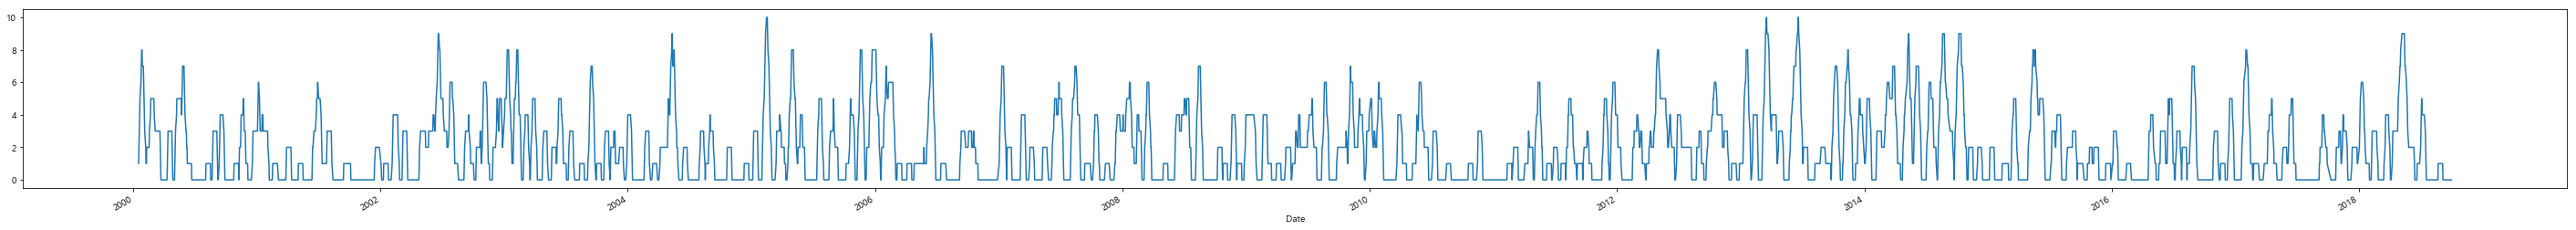

In [208]:
((use_df['sto_K_5-3'] < 30) & (use_df['sto_D_5-3'] < 30)).astype(int).rolling(10).sum().plot(figsize=(50,4))

In [ ]:
def is_stag(df, sto_K, sto_D, thresh=30):
    return ((df[sto_K] < thresh) & (df[sto_D] < thresh)).astype(int)

def is_overheat(df, sto_K, sto_D, thresh=70):
    return ((df[sto_K] > thresh) & (df[sto_D] > thresh)).astype(int)

def is_failure(df, is_stag, is_overheat, look_back=10):
    df[is_stag].rolling(look_back).sum()
    
    
def is_long_timing():
    d
    
def is_shor_timing():
    d
